In [3]:
import os
import sys
import glob
import math
import matplotlib.pyplot as plt
import argparse
import numpy as np
from PIL import Image
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from FusionNet import * 
from UNet import *
from resNet_uNet import *

In [4]:
anno_class_img = Image.open('labels/DJI_0004_2_2.png').convert('RGB')
print(np.array(anno_class_img).shape)

(100, 100, 3)


In [5]:
# inputファイルとlabelsに存在しているファイルを取得
input_dir, label_dir = 'input','labels'
in_files = glob.glob(input_dir+'/*.jpg')
label_files = glob.glob(label_dir+'/*.png')
in_f = [f.split('/')[-1].split('.')[-2] for f in in_files ]
lb_f = [f.split('/')[-1].split('.')[-2] for f in label_files ]
f_name = set(in_f) & set(lb_f)
print('deta count : ',len(list(f_name)))

input_files, annotation_files = [], []
for i in list(f_name):
    input_files.append(input_dir+'/'+i+'.jpg')
    annotation_files.append(label_dir+'/'+i+'.png')
datafiles = list(zip(input_files, annotation_files))
print(datafiles)

deta count :  284
[('input/DJI_0025_2_3.jpg', 'labels/DJI_0025_2_3.png'), ('input/DJI_0011_8_1.jpg', 'labels/DJI_0011_8_1.png'), ('input/DJI_0008_6_1.jpg', 'labels/DJI_0008_6_1.png'), ('input/DJI_0014_7_6.jpg', 'labels/DJI_0014_7_6.png'), ('input/DJI_0007_7_6.jpg', 'labels/DJI_0007_7_6.png'), ('input/DJI_0012_6_1.jpg', 'labels/DJI_0012_6_1.png'), ('input/DJI_0016_6_1.jpg', 'labels/DJI_0016_6_1.png'), ('input/DJI_0018_4_3.jpg', 'labels/DJI_0018_4_3.png'), ('input/DJI_0009_8_3.jpg', 'labels/DJI_0009_8_3.png'), ('input/DJI_0016_8_3.jpg', 'labels/DJI_0016_8_3.png'), ('input/DJI_0022_4_2.jpg', 'labels/DJI_0022_4_2.png'), ('input/DJI_0008_8_1.jpg', 'labels/DJI_0008_8_1.png'), ('input/DJI_0011_8_2.jpg', 'labels/DJI_0011_8_2.png'), ('input/DJI_0016_3_2.jpg', 'labels/DJI_0016_3_2.png'), ('input/DJI_0018_4_1.jpg', 'labels/DJI_0018_4_1.png'), ('input/DJI_0004_7_2.jpg', 'labels/DJI_0004_7_2.png'), ('input/DJI_0007_7_1.jpg', 'labels/DJI_0007_7_1.png'), ('input/DJI_0022_3_1.jpg', 'labels/DJI_0022_3_

In [20]:
class DataTransform():
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 画像の拡大
                RandomRotation(angle=[-10, 10]),  # 回転
                RandomMirror(),  # ランダムミラー
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
            'val': Compose([
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
        }

    def __call__(self, phase, img, anno_class_img):
        return self.data_transform[phase](img, anno_class_img)

In [7]:
class VOCDataset(Dataset):
    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [高さ][幅][色RGB]
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
        #anno_class_img = Image.open(anno_file_path).convert('RGB')
        #anno_np = np.array(anno_class_img)
        #anno_value = np.max(anno_np) + 1
        #anno_class_img_ = np.eye(anno_value)[anno_np]
#         print(anno_class_img)
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)
        return img, anno_class_img

In [8]:
# 動作確認
num_train = math.floor(len(datafiles)*0.8)
num_test = len(datafiles)-num_train
num_all = num_train + num_test

def split_train_test(data):
    id_all   = np.random.choice(num_all, num_all, replace=False)
    id_test  = id_all[0:num_test]
    id_train = id_all[num_test:num_all]
    test_data  = data[id_test]
    train_data = data[id_train]
    return train_data, test_data
    
train_list, test_list = split_train_test(np.asarray(datafiles))
input_train, annotation_train = train_list[:,0], train_list[:,1]
input_val, annotation_val = test_list[:,0], test_list[:,1]

print('input   :: train: %d , test: %d'%(len(input_train), len(input_val)))
print('annotation  :: train: %d , test: %d'%(len(annotation_train), len(annotation_val)))

# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(input_train, annotation_train, phase="train", transform=DataTransform(
    input_size=224, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(input_val, annotation_val, phase="val", transform=DataTransform(
    input_size=224, color_mean=color_mean, color_std=color_std))

# データの取り出し例
# print(val_dataset.__getitem__(0)[0].shape)
# print(val_dataset.__getitem__(0)[1].shape)
# print(val_dataset.__getitem__(0))

input   :: train: 227 , test: 57
annotation  :: train: 227 , test: 57


In [9]:
# データローダーの作成

batch_size = 8

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
# batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
# imges, anno_class_imges = next(batch_iterator)  # 1番目の要素を取り出す
# print(imges.size())  # torch.Size([8, 3, 475, 475])
# print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475])

In [50]:
try:
    generator = torch.load('./model/{}.pkl'.format(args.network))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=2)
model = model.to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

(tensor(28976386), tensor(28976386))

In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

In [53]:
import torch.nn.functional as F
import torch.nn as nn

class Loss(nn.Module):
    
    def __init__(self, aux_weight=0.4):
        super(Loss, self).__init__()
        self.aux_weight = aux_weight

    def forward(self, pred, target):
        pred = pred.permute(0, 2, 3, 1)
        m = pred.shape[0]
        outputs = pred.resize(m*pred.shape[1]*pred.shape[2], 2)
        labels = target.resize(m*target.shape[1]*target.shape[2])
        loss = F.cross_entropy(outputs, labels, reduction='mean')
        #loss_aux = F.cross_entropy(pred[1], target, redirection='mean')

        return loss
    
    
criterion  = Loss(aux_weight=0.4)
#     pred = pred.contiguous()
#     target = target.contiguous()

#     intersection = (pred * target).sum(dim=2).sum(dim=2)
    
#     loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
#     return loss.mean()

In [54]:
from collections import defaultdict
import torch.nn.functional as F

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.to(device).numpy() * target.size(0)
    metrics['dice'] += dice.data.to(device).numpy() * target.size(0)
    metrics['loss'] += loss.data.to(device).numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

#     print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    iteration = 1
    logs = []
    batch_multipier = 3

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        t_iter_start = time.time()
        t_epoch_start = time.time()
        
        num_train_imgs = len(dataloaders_dict['train'].dataset)
        num_val_imgs = len(dataloaders_dict['val'].dataset)
        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                scheduler.step()
                # zero the parameter gradients
                optimizer.zero_grad()
                print(' (train) ')
#                 for param_group in optimizer.param_groups:
#                     print("LR", param_group['lr'])

            else:
                if((epoch+1) % 5 == 0):
                    model.eval()   # Set model to evaluate mode
                    print(' (eval) ')
                else: continue
                    
            count = 0

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders_dict[phase]:
                
                if inputs.size()[0] == 1: continue
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                if torch.set_grad_enabled(phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multipier
                    
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = (criterion(outputs, labels.long()) / batch_multipier)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        count -= 1
                        
                        if (iteration % 10 == 0):
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec.'
                                  .format(iteration,
                                          loss.item()/batch_size*batch_multipier,   
                                          duration))
                            t_iter_start = time.time()
                    else:
                        epoch_val_loss += loss.item() * batch_multipier
                        t_epoch_finish = time.time()
                        print('-----------')
                        print('epoch {} || Epoch_Train_Loss:{:.4f} || Epoch_Val_Looss:{:.4f}'
                               .format(epoch+1,
                                       epoch_train_loss/num_train_imgs,
                                       epoch_val_loss/num_val_imgs))
                        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
                        t_epoch_start - time.time()

                        # statistics
                        epoch_samples += inputs.size(0)
                        logs_epoch = {'epoch':epoch+1,
                                      'train_loss':epoch_train_loss / num_train_imgs,
                                      'val_loss': epoch_val_loss/num_val_imgs}
                        logs.append(logs_epoch)
                        df = pd.DataFrame(logs)
                        df.to_csv('logout.csv')

#             print_metrics(metrics, epoch_samples, phase)
#             epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
#             if phase == 'val' and epoch_loss < best_loss:
#                 print("saving best model")
#                 best_loss = epoch_loss
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         time_elapsed = time.time() - since
#         print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#     print('Best val loss: {:4f}'.format(best_loss))
    torch.save(model.state_dict(), 'model/unet_'+str(epoch+1)+'.pth')

    # load best model weights
    model.load_state_dict(best_model_wts)

In [89]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 2
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

cuda:0
Epoch 0/9
----------
 (train) 
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383C88>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383518>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngIma

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383C88>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383518>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

Epoch 1/9
----------
 (train) 
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile 

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

Epoch 2/9
----------
 (train) 
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile 

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383A90>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453837F0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383C88>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383C88>
Epoch 3/9
----------
 (train) 
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile 

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383908>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383390>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383C88>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383668>
Epoch 4/9
----------
 (train) 
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile 

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3545383780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F35453839E8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB09B0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0D30>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0EB8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0EB8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C88>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0EB8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB09B0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0D30>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0D30>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB09B0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C88>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C88>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0EB8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0D30>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB09B0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0B00>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0D30>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0B00>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0EB8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0B00>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB09B0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

Epoch 9/9
----------
 (train) 
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0B00>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0D30>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB09B0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0D30>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0D30>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB06D8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile 

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C50>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05C0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0860>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB09B0>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0EB8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB05F8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0668>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0EB8>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0C88>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x

<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
 (eval) 
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
<PIL.PngImagePlugin.PngImageFile image mode=P size=100x100 at 0x7F3543AB0780>
-----------
epoch 10 || Epoch_Train_Loss:0.0000 || Epoch_Val_Looss:0.0012
timer: 3.9771 sec.
<PIL.PngImagePlugin.PngImageFile image m

In [ ]:
#Sizes of tensors must match except in dimension 1. Got 119 and 120 in dimension 2
#Target size (torch.Size([8, 224, 224])) must be the same as input size (torch.Size([8, 2, 224, 224]))

推論フェーズ

In [55]:
# 学習済みパラメータをロード
state_dict = torch.load("./model/unet_10.pth",
                        map_location={'cuda:0': 'cpu'})
model.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [56]:
# 入力画像の前処理のクラス
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)

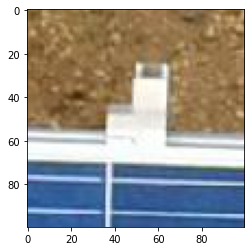

In [148]:



img_index = 4

# 1. 元画像の表示

img_original = Image.open('result/input/DJI_0294_6_2.jpg')   # [高さ][幅][色RGB]
img_width, img_height = img_original.size
plt.imshow(img_original)
plt.show()


In [149]:
model.eval()

# (RGB)の色の平均値と標準偏差
resize = 224
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# TestTransformに変換
base_transform = BaseTransform(resize, color_mean, color_std)
img_transformed = base_transform(img_original)  # torch.Size([3, 224, 224])
x_img = img_transformed.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
print(x.shape)

AttributeError: 'int' object has no attribute 'shape'

torch.Size([1, 2, 224, 224])
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  6 18 21 26 29 32 34 36 37 39 41
 44 47 49 50 51 52 53 54 55 56 59 73 78 82 84 85 89 96 97 98 97 97 91 86
 86 86 86 86 86 86 86 86 85 85 85 84 84 83 82 82 82 88 89 89 88 82 74 51
 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
224
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  8 12 12 14 14 13 13 13 14 14 16 33 34 35
 35 36 36 36 37 37 37 37 37 38 38 38 38 38 38 38 38 38 38 38 38 3

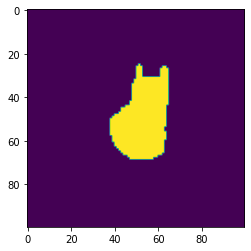

In [159]:
plt.clf()

outputs = model(x_img.to(device)).cpu()
y = outputs  # AuxLoss側は無視
print(y.shape)

# 4. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
print(y.sum(axis=0))
print(len(y.sum(axis=0)))
print(y.sum(axis=1))
print(len(y.sum(axis=1)))

anno_class_ = Image.fromarray(np.uint8(y))
anno_class_ = anno_class_.resize((img_width, img_height), Image.NEAREST)
p_palette = anno_class_.getpalette()
plt.imshow(anno_class_)
plt.show()

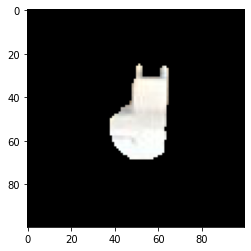

In [160]:
img_result = Image.open('result/input/DJI_0294_6_2.jpg')
anno_class_ = anno_class_.convert('RGBA')

for x in range(img_width):
    for y in range(img_height):
        pixel = anno_class_.getpixel((x,y))
        
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            #白色にする
            img_result.putpixel((x,y),(0,0,0))
        else:
            #trans_img.putpixel((x,y),(r, g, b,150))
            continue

plt.imshow(img_result)
plt.show()
            

In [161]:

def test_segmentation(image):
    img_original = Image.open(image)   # [高さ][幅][色RGB]
    img_width, img_height = img_original.size
    # TestTransformに変換
    base_transform = BaseTransform(resize, color_mean, color_std)
    img_transformed = base_transform(img_original)  # torch.Size([3, 224, 224])
    x_img = img_transformed.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
    
    #3 推論
    outputs = model(x_img.to(device)).cpu()
    y = outputs  # AuxLoss側は無視
    y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
    y = np.argmax(y, axis=0)
    print(len(y.sum(axis=0)))
    
    #4 PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
    result = Image.fromarray(np.uint8(y))
    result = result.resize((img_width, img_height), Image.NEAREST)
    p_palette = result.getpalette()
    result = result.convert('RGBA')

    #5 切り抜き
    img_result = img_original
    for x in range(img_width):
        for y in range(img_height):
            pixel = result.getpixel((x,y))
            r,g,b,a = pixel

            if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
                #白色にする
                img_result.putpixel((x,y),(0,0,0))
            else:
                #trans_img.putpixel((x,y),(r, g, b,150))
                continue
    
    name = image.split('/')[-1].split('.')[-2]
    print('./result/'+name+'.jpg')
    img_result.save('./result/'+name+'.jpg')

In [163]:
model.eval()

# (RGB)の色の平均値と標準偏差
resize = 224
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# testファイルに存在しているファイルを取得
test_dir = '../cut_crump'
test_files = glob.glob(test_dir+'/*.jpg')

for f in test_files:
    test_segmentation(f)

224
./result/DJI_0004_1_1.jpg
224
./result/DJI_0004_2_1.jpg
224
./result/DJI_0004_2_2.jpg
224
./result/DJI_0004_3_1.jpg
224
./result/DJI_0004_3_2.jpg
224
./result/DJI_0004_3_3.jpg
224
./result/DJI_0004_4_1.jpg
224
./result/DJI_0004_4_3.jpg
224
./result/DJI_0004_5_1.jpg
224
./result/DJI_0004_6_1.jpg
224
./result/DJI_0004_7_1.jpg
224
./result/DJI_0004_7_2.jpg
224
./result/DJI_0004_7_3.jpg
224
./result/DJI_0004_8_2.jpg
224
./result/DJI_0005_5_1.jpg
224
./result/DJI_0005_6_1.jpg
224
./result/DJI_0005_6_2.jpg
224
./result/DJI_0125_7_2.jpg
224
./result/DJI_0125_7_3.jpg
224
./result/DJI_0125_8_1.jpg
224
./result/DJI_0125_8_2.jpg
224
./result/DJI_0125_8_3.jpg
224
./result/DJI_0126_1_1.jpg
224
./result/DJI_0126_1_2.jpg
224
./result/DJI_0126_1_3.jpg
224
./result/DJI_0126_2_1.jpg
224
./result/DJI_0126_2_2.jpg
224
./result/DJI_0126_2_3.jpg
224
./result/DJI_0126_3_1.jpg
224
./result/DJI_0126_3_2.jpg
224
./result/DJI_0126_4_1.jpg
224
./result/DJI_0126_4_2.jpg
224
./result/DJI_0126_4_3.jpg
224
./resu

./result/DJI_0048_8_2.jpg
224
./result/DJI_0048_8_3.jpg
224
./result/DJI_0049_1_1.jpg
224
./result/DJI_0049_2_1.jpg
224
./result/DJI_0033_8_1.jpg
224
./result/DJI_0033_8_2.jpg
224
./result/DJI_0034_1_1.jpg
224
./result/DJI_0034_2_1.jpg
224
./result/DJI_0034_2_2.jpg
224
./result/DJI_0034_3_1.jpg
224
./result/DJI_0034_3_2.jpg
224
./result/DJI_0034_3_3.jpg
224
./result/DJI_0034_4_1.jpg
224
./result/DJI_0034_4_2.jpg
224
./result/DJI_0034_5_1.jpg
224
./result/DJI_0034_6_1.jpg
224
./result/DJI_0034_6_2.jpg
224
./result/DJI_0034_7_1.jpg
224
./result/DJI_0034_7_2.jpg
224
./result/DJI_0034_7_3.jpg
224
./result/DJI_0034_8_1.jpg
224
./result/DJI_0011_3_2.jpg
224
./result/DJI_0011_3_3.jpg
224
./result/DJI_0011_3_4.jpg
224
./result/DJI_0011_4_1.jpg
224
./result/DJI_0011_4_2.jpg
224
./result/DJI_0011_7_1.jpg
224
./result/DJI_0011_7_2.jpg
224
./result/DJI_0011_8_1.jpg
224
./result/DJI_0011_8_2.jpg
224
./result/DJI_0011_8_3.jpg
224
./result/DJI_0012_1_1.jpg
224
./result/DJI_0012_1_2.jpg
224
./result/D

./result/DJI_0064_1_3.jpg
224
./result/DJI_0064_2_1.jpg
224
./result/DJI_0064_2_2.jpg
224
./result/DJI_0064_2_3.jpg
224
./result/DJI_0064_3_1.jpg
224
./result/DJI_0064_4_1.jpg
224
./result/DJI_0064_5_1.jpg
224
./result/DJI_0064_5_2.jpg
224
./result/DJI_0064_5_3.jpg
224
./result/DJI_0064_6_1.jpg
224
./result/DJI_0064_6_2.jpg
224
./result/DJI_0064_6_3.jpg
224
./result/DJI_0064_7_1.jpg
224
./result/DJI_0064_8_1.jpg
224
./result/DJI_0064_8_2.jpg
224
./result/DJI_0065_1_1.jpg
224
./result/DJI_0065_1_2.jpg
224
./result/DJI_0065_1_3.jpg
224
./result/DJI_0065_2_1.jpg
224
./result/DJI_0118_6_2.jpg
224
./result/DJI_0118_6_3.jpg
224
./result/DJI_0118_7_1.jpg
224
./result/DJI_0118_7_2.jpg
224
./result/DJI_0118_7_3.jpg
224
./result/DJI_0118_7_4.jpg
224
./result/DJI_0118_8_1.jpg
224
./result/DJI_0118_8_2.jpg
224
./result/DJI_0119_1_1.jpg
224
./result/DJI_0119_1_2.jpg
224
./result/DJI_0119_1_3.jpg
224
./result/DJI_0119_2_1.jpg
224
./result/DJI_0119_2_2.jpg
224
./result/DJI_0119_3_1.jpg
224
./result/D

./result/DJI_0132_5_2.jpg
224
./result/DJI_0132_5_3.jpg
224
./result/DJI_0132_6_1.jpg
224
./result/DJI_0132_6_2.jpg
224
./result/DJI_0132_6_3.jpg
224
./result/DJI_0132_7_1.jpg
224
./result/DJI_0132_7_2.jpg
224
./result/DJI_0132_7_3.jpg
224
./result/DJI_0132_8_1.jpg
224
./result/DJI_0132_8_2.jpg
224
./result/DJI_0132_8_3.jpg
224
./result/DJI_0005_6_4.jpg
224
./result/DJI_0005_7_1.jpg
224
./result/DJI_0005_7_3.jpg
224
./result/DJI_0005_7_4.jpg
224
./result/DJI_0005_7_6.jpg
224
./result/DJI_0005_8_2.jpg
224
./result/DJI_0005_8_3.jpg
224
./result/DJI_0005_8_4.jpg
224
./result/DJI_0005_8_5.jpg
224
./result/DJI_0006_7_2.jpg
224
./result/DJI_0006_7_3.jpg
224
./result/DJI_0006_8_1.jpg
224
./result/DJI_0006_8_2.jpg
224
./result/DJI_0007_5_1.jpg
224
./result/DJI_0007_5_2.jpg
224
./result/DJI_0007_5_3.jpg
224
./result/DJI_0007_6_1.jpg
224
./result/DJI_0007_6_3.jpg
224
./result/DJI_0007_7_1.jpg
224
./result/DJI_0007_7_6.jpg
224
./result/DJI_0007_7_8.jpg
224
./result/DJI_0074_5_3.jpg
224
./result/D

224
./result/DJI_0052_7_2.jpg
224
./result/DJI_0052_7_3.jpg
224
./result/DJI_0052_7_4.jpg
224
./result/DJI_0052_7_5.jpg
224
./result/DJI_0052_8_1.jpg
224
./result/DJI_0052_8_2.jpg
224
./result/DJI_0052_8_3.jpg
224
./result/DJI_0052_8_4.jpg
224
./result/DJI_0052_8_5.jpg
224
./result/DJI_0053_5_1.jpg
224
./result/DJI_0053_5_2.jpg
224
./result/DJI_0053_5_3.jpg
224
./result/DJI_0053_5_4.jpg
224
./result/DJI_0053_5_5.jpg
224
./result/DJI_0053_6_1.jpg
224
./result/DJI_0158_8_1.jpg
224
./result/DJI_0158_8_2.jpg
224
./result/DJI_0158_8_3.jpg
224
./result/DJI_0158_8_4.jpg
224
./result/DJI_0158_8_5.jpg
224
./result/DJI_0159_1_1.jpg
224
./result/DJI_0159_1_2.jpg
224
./result/DJI_0159_1_3.jpg
224
./result/DJI_0159_1_4.jpg
224
./result/DJI_0159_1_5.jpg
224
./result/DJI_0159_1_6.jpg
224
./result/DJI_0159_2_1.jpg
224
./result/DJI_0159_2_2.jpg
224
./result/DJI_0159_2_3.jpg
224
./result/DJI_0159_2_4.jpg
224
./result/DJI_0159_3_1.jpg
224
./result/DJI_0065_2_3.jpg
224
./result/DJI_0065_3_1.jpg
224
./resu

./result/DJI_0155_7_1.jpg
224
./result/DJI_0155_7_2.jpg
224
./result/DJI_0155_7_3.jpg
224
./result/DJI_0155_8_1.jpg
224
./result/DJI_0155_8_2.jpg
224
./result/DJI_0155_8_3.jpg
224
./result/DJI_0156_1_1.jpg
224
./result/DJI_0156_5_1.jpg
224
./result/DJI_0156_5_2.jpg
224
./result/DJI_0086_3_2.jpg
224
./result/DJI_0086_4_1.jpg
224
./result/DJI_0086_4_2.jpg
224
./result/DJI_0087_1_1.jpg
224
./result/DJI_0087_1_2.jpg
224
./result/DJI_0087_1_3.jpg
224
./result/DJI_0087_2_1.jpg
224
./result/DJI_0087_2_2.jpg
224
./result/DJI_0087_2_3.jpg
224
./result/DJI_0087_2_4.jpg
224
./result/DJI_0087_2_5.jpg
224
./result/DJI_0087_3_1.jpg
224
./result/DJI_0087_4_1.jpg
224
./result/DJI_0087_5_1.jpg
224
./result/DJI_0087_5_2.jpg
224
./result/DJI_0087_6_1.jpg
224
./result/DJI_0131_2_2.jpg
224
./result/DJI_0131_3_1.jpg
224
./result/DJI_0131_3_2.jpg
224
./result/DJI_0131_3_3.jpg
224
./result/DJI_0131_4_1.jpg
224
./result/DJI_0131_4_2.jpg
224
./result/DJI_0131_4_3.jpg
224
./result/DJI_0131_5_1.jpg
224
./result/D

224
./result/DJI_0092_2_3.jpg
224
./result/DJI_0092_2_4.jpg
224
./result/DJI_0092_3_1.jpg
224
./result/DJI_0092_4_1.jpg
224
./result/DJI_0092_4_2.jpg
224
./result/DJI_0092_5_1.jpg
224
./result/DJI_0092_5_2.jpg
224
./result/DJI_0092_5_3.jpg
224
./result/DJI_0092_6_1.jpg
224
./result/DJI_0092_6_2.jpg
224
./result/DJI_0092_6_3.jpg
224
./result/DJI_0092_7_1.jpg
224
./result/DJI_0092_8_1.jpg
224
./result/DJI_0093_1_1.jpg
224
./result/DJI_0134_3_1.jpg
224
./result/DJI_0134_3_2.jpg
224
./result/DJI_0134_4_1.jpg
224
./result/DJI_0134_4_2.jpg
224
./result/DJI_0134_4_3.jpg
224
./result/DJI_0134_5_1.jpg
224
./result/DJI_0134_5_2.jpg
224
./result/DJI_0134_6_1.jpg
224
./result/DJI_0134_6_2.jpg
224
./result/DJI_0134_6_3.jpg
224
./result/DJI_0134_7_1.jpg
224
./result/DJI_0134_7_2.jpg
224
./result/DJI_0134_7_3.jpg
224
./result/DJI_0134_8_1.jpg
224
./result/DJI_0134_8_2.jpg
224
./result/DJI_0134_8_3.jpg
224
./result/DJI_0108_8_7.jpg
224
./result/DJI_0109_5_1.jpg
224
./result/DJI_0109_5_2.jpg
224
./resu

224
./result/DJI_0106_3_3.jpg
224
./result/DJI_0106_4_1.jpg
224
./result/DJI_0106_4_2.jpg
224
./result/DJI_0106_4_3.jpg
224
./result/DJI_0106_5_1.jpg
224
./result/DJI_0045_3_1.jpg
224
./result/DJI_0045_3_2.jpg
224
./result/DJI_0045_3_3.jpg
224
./result/DJI_0045_4_1.jpg
224
./result/DJI_0045_4_2.jpg
224
./result/DJI_0045_4_3.jpg
224
./result/DJI_0045_5_1.jpg
224
./result/DJI_0045_5_2.jpg
224
./result/DJI_0045_6_1.jpg
224
./result/DJI_0045_7_1.jpg
224
./result/DJI_0045_7_2.jpg
224
./result/DJI_0045_7_3.jpg
224
./result/DJI_0045_7_4.jpg
224
./result/DJI_0045_8_1.jpg
224
./result/DJI_0045_8_2.jpg
224
./result/DJI_0045_8_3.jpg
224
./result/DJI_0046_1_1.jpg
224
./result/DJI_0046_2_1.jpg
224
./result/DJI_0046_3_1.jpg
224
./result/DJI_0046_3_2.jpg
224
./result/DJI_0046_3_3.jpg
224
./result/DJI_0046_3_4.jpg
224
./result/DJI_0046_3_5.jpg
224
./result/DJI_0046_3_6.jpg
224
./result/DJI_0046_4_1.jpg
224
./result/DJI_0046_4_2.jpg
224
./result/DJI_0046_4_3.jpg
224
./result/DJI_0046_4_4.jpg
224
./resu

224
./result/DJI_0114_1_3.jpg
224
./result/DJI_0114_2_1.jpg
224
./result/DJI_0114_2_2.jpg
224
./result/DJI_0114_2_3.jpg
224
./result/DJI_0114_3_1.jpg
224
./result/DJI_0114_3_2.jpg
224
./result/DJI_0114_3_3.jpg
224
./result/DJI_0114_4_1.jpg
224
./result/DJI_0114_4_2.jpg
224
./result/DJI_0087_6_3.jpg
224
./result/DJI_0087_6_4.jpg
224
./result/DJI_0087_7_1.jpg
224
./result/DJI_0087_8_1.jpg
224
./result/DJI_0087_8_2.jpg
224
./result/DJI_0088_1_1.jpg
224
./result/DJI_0088_1_2.jpg
224
./result/DJI_0088_1_3.jpg
224
./result/DJI_0088_2_1.jpg
224
./result/DJI_0088_2_2.jpg
224
./result/DJI_0088_2_3.jpg
224
./result/DJI_0088_3_1.jpg
224
./result/DJI_0088_4_1.jpg
224
./result/DJI_0088_5_1.jpg
224
./result/DJI_0088_5_2.jpg
224
./result/DJI_0088_5_3.jpg
224
./result/DJI_0088_5_4.jpg
224
./result/DJI_0142_8_3.jpg
224
./result/DJI_0143_1_1.jpg
224
./result/DJI_0143_1_2.jpg
224
./result/DJI_0143_1_3.jpg
224
./result/DJI_0143_2_1.jpg
224
./result/DJI_0143_2_2.jpg
224
./result/DJI_0143_2_3.jpg
224
./resu

./result/DJI_0147_5_4.jpg
224
./result/DJI_0147_5_5.jpg
224
./result/DJI_0147_5_6.jpg
224
./result/DJI_0147_6_1.jpg
224
./result/DJI_0147_6_2.jpg
224
./result/DJI_0147_6_3.jpg
224
./result/DJI_0147_6_4.jpg
224
./result/DJI_0147_6_5.jpg
224
./result/DJI_0147_7_1.jpg
224
./result/DJI_0147_7_2.jpg
224
./result/DJI_0147_7_3.jpg
224
./result/DJI_0147_7_4.jpg
224
./result/DJI_0147_7_5.jpg
224
./result/DJI_0147_7_6.jpg
224
./result/DJI_0081_1_1.jpg
224
./result/DJI_0081_1_2.jpg
224
./result/DJI_0081_1_3.jpg
224
./result/DJI_0081_2_1.jpg
224
./result/DJI_0081_2_2.jpg
224
./result/DJI_0081_2_3.jpg
224
./result/DJI_0081_3_1.jpg
224
./result/DJI_0081_4_1.jpg
224
./result/DJI_0081_5_1.jpg
224
./result/DJI_0081_5_2.jpg
224
./result/DJI_0081_5_3.jpg
224
./result/DJI_0081_6_1.jpg
224
./result/DJI_0081_6_2.jpg
224
./result/DJI_0081_6_3.jpg
224
./result/DJI_0081_6_4.jpg
224
./result/DJI_0081_7_1.jpg
224
./result/DJI_0081_8_1.jpg
224
./result/DJI_0081_8_2.jpg
224
./result/DJI_0081_8_3.jpg
224
./result/D

./result/DJI_0093_3_2.jpg
224
./result/DJI_0093_4_1.jpg
224
./result/DJI_0093_4_2.jpg
224
./result/DJI_0094_1_1.jpg
224
./result/DJI_0094_1_2.jpg
224
./result/DJI_0094_1_3.jpg
224
./result/DJI_0094_2_1.jpg
224
./result/DJI_0094_2_2.jpg
224
./result/DJI_0094_2_3.jpg
224
./result/DJI_0150_6_1.jpg
224
./result/DJI_0150_6_2.jpg
224
./result/DJI_0150_7_1.jpg
224
./result/DJI_0150_7_2.jpg
224
./result/DJI_0150_7_3.jpg
224
./result/DJI_0150_8_1.jpg
224
./result/DJI_0150_8_2.jpg
224
./result/DJI_0150_8_3.jpg
224
./result/DJI_0151_1_1.jpg
224
./result/DJI_0151_1_2.jpg
224
./result/DJI_0151_2_1.jpg
224
./result/DJI_0151_2_2.jpg
224
./result/DJI_0151_3_1.jpg
224
./result/DJI_0151_3_2.jpg
224
./result/DJI_0151_3_3.jpg
224
./result/DJI_0151_4_1.jpg
224
./result/DJI_0151_4_2.jpg
224
./result/DJI_0132_3_1.jpg
224
./result/DJI_0133_1_1.jpg
224
./result/DJI_0134_2_3.jpg
224
./result/DJI_0135_1_1.jpg
224
./result/DJI_0135_8_3.jpg
224
./result/DJI_0136_7_2.jpg
224
./result/DJI_0137_7_1.jpg
224
./result/D

./result/DJI_0016_7_1.jpg
224
./result/DJI_0016_7_3.jpg
224
./result/DJI_0016_8_1.jpg
224
./result/DJI_0016_8_2.jpg
224
./result/DJI_0016_8_3.jpg
224
./result/DJI_0017_1_1.jpg
224
./result/DJI_0017_1_2.jpg
224
./result/DJI_0017_1_3.jpg
224
./result/DJI_0021_7_3.jpg
224
./result/DJI_0021_7_4.jpg
224
./result/DJI_0021_7_5.jpg
224
./result/DJI_0021_7_6.jpg
224
./result/DJI_0021_8_1.jpg
224
./result/DJI_0021_8_2.jpg
224
./result/DJI_0021_8_4.jpg
224
./result/DJI_0022_2_1.jpg
224
./result/DJI_0022_3_1.jpg
224
./result/DJI_0022_3_2.jpg
224
./result/DJI_0022_3_3.jpg
224
./result/DJI_0022_4_1.jpg
224
./result/DJI_0022_4_2.jpg
224
./result/DJI_0022_5_2.jpg
224
./result/DJI_0022_6_2.jpg
224
./result/DJI_0022_6_4.jpg
224
./result/DJI_0022_7_1.jpg
224
./result/DJI_0022_7_2.jpg
224
./result/DJI_0022_8_2.jpg
224
./result/DJI_0022_8_4.jpg
224
./result/DJI_0023_1_2.jpg
224
./result/DJI_0023_2_1.jpg
224
./result/DJI_0023_3_1.jpg
224
./result/DJI_0023_3_2.jpg
224
./result/DJI_0023_3_4.jpg
224
./result/D

./result/DJI_0133_4_6.jpg
224
./result/DJI_0134_1_1.jpg
224
./result/DJI_0134_1_2.jpg
224
./result/DJI_0134_1_3.jpg
224
./result/DJI_0134_2_1.jpg
224
./result/DJI_0134_2_2.jpg
224
./result/DJI_0187_6_2.jpg
224
./result/DJI_0187_7_1.jpg
224
./result/DJI_0187_7_2.jpg
224
./result/DJI_0187_7_3.jpg
224
./result/DJI_0187_8_1.jpg
224
./result/DJI_0187_8_2.jpg
224
./result/DJI_0188_1_1.jpg
224
./result/DJI_0188_1_2.jpg
224
./result/DJI_0188_2_1.jpg
224
./result/DJI_0188_2_2.jpg
224
./result/DJI_0188_3_1.jpg
224
./result/DJI_0188_3_2.jpg
224
./result/DJI_0188_3_3.jpg
224
./result/DJI_0188_4_1.jpg
224
./result/DJI_0188_4_2.jpg
224
./result/DJI_0188_4_3.jpg
224
./result/DJI_0171_8_1.jpg
224
./result/DJI_0172_6_1.jpg
224
./result/DJI_0173_3_6.jpg
224
./result/DJI_0175_1_1.jpg
224
./result/DJI_0176_6_3.jpg
224
./result/DJI_0177_6_4.jpg
224
./result/DJI_0178_2_2.jpg
224
./result/DJI_0179_1_2.jpg
224
./result/DJI_0179_8_2.jpg
224
./result/DJI_0180_4_3.jpg
224
./result/DJI_0182_1_1.jpg
224
./result/D

./result/DJI_0204_1_3.jpg
224
./result/DJI_0204_2_1.jpg
224
./result/DJI_0204_2_2.jpg
224
./result/DJI_0204_3_1.jpg
224
./result/DJI_0204_3_2.jpg
224
./result/DJI_0204_3_3.jpg
224
./result/DJI_0204_4_1.jpg
224
./result/DJI_0204_4_2.jpg
224
./result/DJI_0204_4_3.jpg
224
./result/DJI_0204_4_4.jpg
224
./result/DJI_0204_4_5.jpg
224
./result/DJI_0204_5_1.jpg
224
./result/DJI_0204_5_2.jpg
224
./result/DJI_0204_5_3.jpg
224
./result/DJI_0204_6_1.jpg
224
./result/DJI_0204_6_2.jpg
224
./result/DJI_0205_1_1.jpg
224
./result/DJI_0205_1_2.jpg
224
./result/DJI_0205_1_3.jpg
224
./result/DJI_0188_4_4.jpg
224
./result/DJI_0190_3_1.jpg
224
./result/DJI_0191_5_1.jpg
224
./result/DJI_0192_8_1.jpg
224
./result/DJI_0194_4_3.jpg
224
./result/DJI_0195_5_1.jpg
224
./result/DJI_0196_3_1.jpg
224
./result/DJI_0197_2_3.jpg
224
./result/DJI_0198_2_5.jpg
224
./result/DJI_0199_3_3.jpg
224
./result/DJI_0200_2_1.jpg
224
./result/DJI_0200_8_2.jpg
224
./result/DJI_0201_7_3.jpg
224
./result/DJI_0202_7_2.jpg
224
./result/D

./result/DJI_0218_1_2.jpg
224
./result/DJI_0218_2_1.jpg
224
./result/DJI_0218_2_2.jpg
224
./result/DJI_0218_2_3.jpg
224
./result/DJI_0218_3_1.jpg
224
./result/DJI_0218_3_2.jpg
224
./result/DJI_0218_4_1.jpg
224
./result/DJI_0218_4_2.jpg
224
./result/DJI_0218_4_3.jpg
224
./result/DJI_0218_5_1.jpg
224
./result/DJI_0219_1_1.jpg
224
./result/DJI_0205_1_4.jpg
224
./result/DJI_0205_8_1.jpg
224
./result/DJI_0206_6_3.jpg
224
./result/DJI_0207_5_1.jpg
224
./result/DJI_0208_5_6.jpg
224
./result/DJI_0208_8_4.jpg
224
./result/DJI_0209_7_2.jpg
224
./result/DJI_0210_5_2.jpg
224
./result/DJI_0211_3_1.jpg
224
./result/DJI_0212_3_1.jpg
224
./result/DJI_0213_3_3.jpg
224
./result/DJI_0214_2_1.jpg
224
./result/DJI_0214_8_1.jpg
224
./result/DJI_0215_7_4.jpg
224
./result/DJI_0216_8_2.jpg
224
./result/DJI_0219_1_3.jpg
224
./result/DJI_0219_1_4.jpg
224
./result/DJI_0219_1_5.jpg
224
./result/DJI_0219_1_6.jpg
224
./result/DJI_0219_2_1.jpg
224
./result/DJI_0219_2_2.jpg
224
./result/DJI_0219_2_3.jpg
224
./result/D

224
./result/DJI_0233_1_4.jpg
224
./result/DJI_0233_1_5.jpg
224
./result/DJI_0233_1_6.jpg
224
./result/DJI_0219_1_2.jpg
224
./result/DJI_0219_4_3.jpg
224
./result/DJI_0220_5_3.jpg
224
./result/DJI_0221_3_2.jpg
224
./result/DJI_0222_5_3.jpg
224
./result/DJI_0222_8_2.jpg
224
./result/DJI_0224_2_2.jpg
224
./result/DJI_0225_1_1.jpg
224
./result/DJI_0225_7_1.jpg
224
./result/DJI_0227_2_2.jpg
224
./result/DJI_0227_8_3.jpg
224
./result/DJI_0228_6_1.jpg
224
./result/DJI_0229_6_5.jpg
224
./result/DJI_0230_7_1.jpg
224
./result/DJI_0231_5_1.jpg
224
./result/DJI_0233_2_2.jpg
224
./result/DJI_0233_2_3.jpg
224
./result/DJI_0233_2_4.jpg
224
./result/DJI_0233_3_1.jpg
224
./result/DJI_0233_3_2.jpg
224
./result/DJI_0233_3_3.jpg
224
./result/DJI_0233_3_4.jpg
224
./result/DJI_0233_3_5.jpg
224
./result/DJI_0233_3_6.jpg
224
./result/DJI_0233_4_1.jpg
224
./result/DJI_0233_4_2.jpg
224
./result/DJI_0233_4_3.jpg
224
./result/DJI_0233_4_4.jpg
224
./result/DJI_0233_4_5.jpg
224
./result/DJI_0233_4_6.jpg
224
./resu

./result/DJI_0235_5_3.jpg
224
./result/DJI_0236_6_3.jpg
224
./result/DJI_0237_6_1.jpg
224
./result/DJI_0238_4_2.jpg
224
./result/DJI_0239_3_1.jpg
224
./result/DJI_0240_1_1.jpg
224
./result/DJI_0240_7_3.jpg
224
./result/DJI_0242_5_2.jpg
224
./result/DJI_0243_6_2.jpg
224
./result/DJI_0244_5_3.jpg
224
./result/DJI_0245_2_2.jpg
224
./result/DJI_0245_8_2.jpg
224
./result/DJI_0247_3_5.jpg
224
./result/DJI_0247_3_6.jpg
224
./result/DJI_0247_4_1.jpg
224
./result/DJI_0247_4_2.jpg
224
./result/DJI_0247_4_3.jpg
224
./result/DJI_0247_4_4.jpg
224
./result/DJI_0248_1_1.jpg
224
./result/DJI_0248_1_2.jpg
224
./result/DJI_0248_2_1.jpg
224
./result/DJI_0248_2_2.jpg
224
./result/DJI_0248_2_3.jpg
224
./result/DJI_0248_3_1.jpg
224
./result/DJI_0248_3_2.jpg
224
./result/DJI_0248_3_3.jpg
224
./result/DJI_0248_4_1.jpg
224
./result/DJI_0248_4_2.jpg
224
./result/DJI_0248_5_2.jpg
224
./result/DJI_0248_5_3.jpg
224
./result/DJI_0248_6_1.jpg
224
./result/DJI_0248_6_2.jpg
224
./result/DJI_0248_6_3.jpg
224
./result/D

224
./result/DJI_0254_2_5.jpg
224
./result/DJI_0255_2_3.jpg
224
./result/DJI_0256_4_1.jpg
224
./result/DJI_0257_4_1.jpg
224
./result/DJI_0258_5_3.jpg
224
./result/DJI_0258_8_1.jpg
224
./result/DJI_0259_4_3.jpg
224
./result/DJI_0260_8_2.jpg
224
./result/DJI_0260_8_3.jpg
224
./result/DJI_0261_1_1.jpg
224
./result/DJI_0261_1_2.jpg
224
./result/DJI_0261_1_3.jpg
224
./result/DJI_0261_1_4.jpg
224
./result/DJI_0261_1_5.jpg
224
./result/DJI_0261_1_6.jpg
224
./result/DJI_0261_2_1.jpg
224
./result/DJI_0261_2_2.jpg
224
./result/DJI_0261_2_3.jpg
224
./result/DJI_0261_2_4.jpg
224
./result/DJI_0261_2_5.jpg
224
./result/DJI_0261_2_6.jpg
224
./result/DJI_0261_3_1.jpg
224
./result/DJI_0261_3_2.jpg
224
./result/DJI_0261_3_4.jpg
224
./result/DJI_0261_4_1.jpg
224
./result/DJI_0261_4_2.jpg
224
./result/DJI_0261_8_1.jpg
224
./result/DJI_0261_8_2.jpg
224
./result/DJI_0262_1_1.jpg
224
./result/DJI_0262_1_2.jpg
224
./result/DJI_0262_2_1.jpg
224
./result/DJI_0262_2_2.jpg
224
./result/DJI_0262_2_3.jpg
224
./resu

./result/DJI_0263_7_3.jpg
224
./result/DJI_0264_8_3.jpg
224
./result/DJI_0265_8_1.jpg
224
./result/DJI_0266_5_2.jpg
224
./result/DJI_0267_3_4.jpg
224
./result/DJI_0268_1_3.jpg
224
./result/DJI_0268_4_2.jpg
224
./result/DJI_0270_1_2.jpg
224
./result/DJI_0270_8_2.jpg
224
./result/DJI_0272_6_2.jpg
224
./result/DJI_0273_3_2.jpg
224
./result/DJI_0274_2_2.jpg
224
./result/DJI_0275_4_5.jpg
224
./result/DJI_0275_4_6.jpg
224
./result/DJI_0276_1_1.jpg
224
./result/DJI_0276_1_2.jpg
224
./result/DJI_0276_2_1.jpg
224
./result/DJI_0276_2_2.jpg
224
./result/DJI_0276_3_1.jpg
224
./result/DJI_0276_3_2.jpg
224
./result/DJI_0276_3_3.jpg
224
./result/DJI_0276_4_1.jpg
224
./result/DJI_0276_4_2.jpg
224
./result/DJI_0276_4_3.jpg
224
./result/DJI_0277_1_1.jpg
224
./result/DJI_0277_1_2.jpg
224
./result/DJI_0277_2_1.jpg
224
./result/DJI_0277_2_2.jpg
224
./result/DJI_0277_2_4.jpg
224
./result/DJI_0277_3_1.jpg
224
./result/DJI_0277_3_2.jpg
224
./result/DJI_0277_4_1.jpg
224
./result/DJI_0277_4_2.jpg
224
./result/D

./result/DJI_0283_4_2.jpg
224
./result/DJI_0284_8_2.jpg
224
./result/DJI_0286_7_2.jpg
224
./result/DJI_0288_5_1.jpg
224
./result/DJI_0289_7_3.jpg
224
./result/DJI_0291_3_1.jpg
224
./result/DJI_0293_1_1.jpg
224
./result/DJI_0294_6_3.jpg
224
./result/DJI_0294_7_1.jpg
224
./result/DJI_0294_7_2.jpg
224
./result/DJI_0294_8_1.jpg
224
./result/DJI_0294_8_2.jpg
224
./result/DJI_0294_8_3.jpg
224
./result/DJI_0295_1_1.jpg
224
./result/DJI_0295_1_2.jpg
224
./result/DJI_0295_1_3.jpg
224
./result/DJI_0295_5_1.jpg
224
./result/DJI_0295_5_2.jpg
224
./result/DJI_0295_6_1.jpg
224
./result/DJI_0295_6_2.jpg
224
./result/DJI_0295_6_3.jpg
224
./result/DJI_0295_6_4.jpg
224
./result/DJI_0295_6_5.jpg
224
./result/DJI_0295_6_7.jpg
224
./result/DJI_0295_7_1.jpg
224
./result/DJI_0295_7_2.jpg
224
./result/DJI_0295_7_3.jpg
224
./result/DJI_0295_7_4.jpg
224
./result/DJI_0295_7_5.jpg
224
./result/DJI_0295_8_1.jpg
224
./result/DJI_0295_8_2.jpg
224
./result/DJI_0295_8_3.jpg
224
./result/DJI_0295_8_4.jpg
224
./result/D

./result/DJI_0306_2_1.jpg
224
./result/DJI_0307_2_3.jpg
224
./result/DJI_0308_1_2.jpg
224
./result/DJI_0308_7_3.jpg
224
./result/DJI_0310_7_2.jpg
224
./result/DJI_0310_8_1.jpg
224
./result/DJI_0310_8_2.jpg
224
./result/DJI_0310_8_3.jpg
224
./result/DJI_0311_2_1.jpg
224
./result/DJI_0311_2_2.jpg
224
./result/DJI_0311_2_3.jpg
224
./result/DJI_0311_3_1.jpg
224
./result/DJI_0311_3_2.jpg
224
./result/DJI_0311_3_3.jpg
224
./result/DJI_0311_4_1.jpg
224
./result/DJI_0311_4_2.jpg
224
./result/DJI_0311_4_3.jpg
224
./result/DJI_0311_5_1.jpg
224
./result/DJI_0311_5_2.jpg
224
./result/DJI_0311_6_1.jpg
224
./result/DJI_0311_6_3.jpg
224
./result/DJI_0311_6_4.jpg
224
./result/DJI_0311_7_1.jpg
224
./result/DJI_0311_7_2.jpg
224
./result/DJI_0311_7_3.jpg
224
./result/DJI_0311_8_1.jpg
224
./result/DJI_0311_8_2.jpg
224
./result/DJI_0311_8_3.jpg
224
./result/DJI_0312_1_1.jpg
224
./result/DJI_0312_1_2.jpg
224
./result/DJI_0312_2_1.jpg
224
./result/DJI_0312_2_2.jpg
224
./result/DJI_0312_2_3.jpg
224
./result/D

224
./result/DJI_0325_8_3.jpg
224
./result/DJI_0326_1_1.jpg
224
./result/DJI_0326_1_2.jpg
224
./result/DJI_0326_2_1.jpg
224
./result/DJI_0326_2_2.jpg
224
./result/DJI_0326_2_3.jpg
224
./result/DJI_0326_3_1.jpg
224
./result/DJI_0326_3_2.jpg
224
./result/DJI_0326_3_3.jpg
224
./result/DJI_0326_4_1.jpg
224
./result/DJI_0326_4_2.jpg
224
./result/DJI_0326_4_3.jpg
224
./result/DJI_0326_4_4.jpg
224
./result/DJI_0326_5_1.jpg
224
./result/DJI_0326_5_2.jpg
224
./result/DJI_0326_6_1.jpg
224
./result/DJI_0326_6_3.jpg
224
./result/DJI_0326_7_1.jpg
224
./result/DJI_0326_7_2.jpg
224
./result/DJI_0326_7_3.jpg
224
./result/DJI_0326_8_1.jpg
224
./result/DJI_0326_8_2.jpg
224
./result/DJI_0326_8_3.jpg
224
./result/DJI_0327_1_1.jpg
224
./result/DJI_0327_1_2.jpg
224
./result/DJI_0327_2_1.jpg
224
./result/DJI_0327_2_2.jpg
224
./result/DJI_0327_2_3.jpg
224
./result/DJI_0327_3_1.jpg
224
./result/DJI_0327_3_2.jpg
224
./result/DJI_0327_3_3.jpg
224
./result/DJI_0327_4_1.jpg
224
./result/DJI_0328_1_1.jpg
224
./resu

./result/DJI_0336_6_3.jpg
224
./result/DJI_0337_6_6.jpg
224
./result/DJI_0338_5_1.jpg
224
./result/DJI_0339_3_1.jpg
224
./result/DJI_0340_1_2.jpg
224
./result/DJI_0340_8_2.jpg
224
./result/DJI_0342_8_3.jpg
224
./result/DJI_0343_4_1.jpg
224
./result/DJI_0343_5_1.jpg
224
./result/DJI_0343_5_2.jpg
224
./result/DJI_0343_5_3.jpg
224
./result/DJI_0343_6_1.jpg
224
./result/DJI_0343_6_2.jpg
224
./result/DJI_0343_6_3.jpg
224
./result/DJI_0343_7_1.jpg
224
./result/DJI_0343_7_2.jpg
224
./result/DJI_0343_8_1.jpg
224
./result/DJI_0343_8_2.jpg
224
./result/DJI_0343_8_3.jpg
224
./result/DJI_0344_5_1.jpg
224
./result/DJI_0344_5_2.jpg
224
./result/DJI_0344_5_3.jpg
224
./result/DJI_0344_5_5.jpg
224
./result/DJI_0344_5_6.jpg
224
./result/DJI_0344_6_1.jpg
224
./result/DJI_0344_6_2.jpg
224
./result/DJI_0344_6_3.jpg
224
./result/DJI_0344_6_4.jpg
224
./result/DJI_0344_6_5.jpg
224
./result/DJI_0344_6_6.jpg
224
./result/DJI_0344_7_1.jpg
224
./result/DJI_0344_7_2.jpg
224
./result/DJI_0344_7_3.jpg
224
./result/D

./result/DJI_0352_7_2.jpg
224
./result/DJI_0353_3_1.jpg
224
./result/DJI_0353_8_4.jpg
224
./result/DJI_0355_2_4.jpg
224
./result/DJI_0355_2_5.jpg
224
./result/DJI_0355_2_6.jpg
224
./result/DJI_0355_2_7.jpg
224
./result/DJI_0355_3_1.jpg
224
./result/DJI_0355_3_2.jpg
224
./result/DJI_0355_3_3.jpg
224
./result/DJI_0355_3_4.jpg
224
./result/DJI_0355_3_5.jpg
224
./result/DJI_0355_4_1.jpg
224
./result/DJI_0355_4_2.jpg
224
./result/DJI_0355_4_3.jpg
224
./result/DJI_0355_4_4.jpg
224
./result/DJI_0355_4_5.jpg
224
./result/DJI_0355_4_6.jpg
224
./result/DJI_0355_4_7.jpg
224
./result/DJI_0356_1_2.jpg
224
./result/DJI_0356_1_3.jpg
224
./result/DJI_0356_2_1.jpg
224
./result/DJI_0356_2_2.jpg
224
./result/DJI_0356_2_3.jpg
224
./result/DJI_0356_3_1.jpg
224
./result/DJI_0356_3_2.jpg
224
./result/DJI_0356_4_1.jpg
224
./result/DJI_0356_4_2.jpg
224
./result/DJI_0356_4_3.jpg
224
./result/DJI_0356_5_1.jpg
224
./result/DJI_0356_5_2.jpg
224
./result/DJI_0356_5_3.jpg
224
./result/DJI_0356_6_1.jpg
224
./result/D

./result/DJI_0368_7_1.jpg
224
./result/DJI_0368_7_2.jpg
224
./result/DJI_0368_8_1.jpg
224
./result/DJI_0368_8_2.jpg
224
./result/DJI_0369_1_1.jpg
224
./result/DJI_0369_1_2.jpg
224
./result/DJI_0369_1_3.jpg
224
./result/DJI_0369_1_4.jpg
224
./result/DJI_0369_1_5.jpg
224
./result/DJI_0369_2_1.jpg
224
./result/DJI_0369_2_2.jpg
224
./result/DJI_0369_2_3.jpg
224
./result/DJI_0369_2_4.jpg
224
./result/DJI_0369_2_6.jpg
224
./result/DJI_0369_3_1.jpg
224
./result/DJI_0369_3_2.jpg
224
./result/DJI_0369_3_3.jpg
224
./result/DJI_0369_3_4.jpg
224
./result/DJI_0369_3_5.jpg
224
./result/DJI_0369_3_6.jpg
224
./result/DJI_0369_3_7.jpg
224
./result/DJI_0369_4_1.jpg
224
./result/DJI_0369_4_2.jpg
224
./result/DJI_0369_4_3.jpg
224
./result/DJI_0369_4_4.jpg
224
./result/DJI_0369_4_5.jpg
224
./result/DJI_0370_1_1.jpg
224
./result/DJI_0370_1_2.jpg
224
./result/DJI_0370_2_1.jpg
224
./result/DJI_0370_3_1.jpg
224
./result/DJI_0370_3_2.jpg
224
./result/DJI_0370_3_3.jpg
224
./result/DJI_0370_4_1.jpg
224
./result/D

224
./result/DJI_0389_1_3.jpg
224
./result/DJI_0389_2_1.jpg
224
./result/DJI_0389_2_2.jpg
224
./result/DJI_0389_3_1.jpg
224
./result/DJI_0389_3_2.jpg
224
./result/DJI_0389_5_1.jpg
224
./result/DJI_0389_5_2.jpg
224
./result/DJI_0389_6_2.jpg
224
./result/DJI_0389_7_1.jpg
224
./result/DJI_0389_7_2.jpg
224
./result/DJI_0389_7_3.jpg
224
./result/DJI_0389_8_1.jpg
224
./result/DJI_0389_8_2.jpg
224
./result/DJI_0389_8_3.jpg
224
./result/DJI_0389_8_4.jpg
224
./result/DJI_0389_8_5.jpg
224
./result/DJI_0389_8_6.jpg
224
./result/DJI_0390_5_1.jpg
224
./result/DJI_0390_5_2.jpg
224
./result/DJI_0390_5_3.jpg
224
./result/DJI_0390_6_1.jpg
224
./result/DJI_0390_6_2.jpg
224
./result/DJI_0390_7_1.jpg
224
./result/DJI_0390_7_3.jpg
224
./result/DJI_0390_8_1.jpg
224
./result/DJI_0390_8_2.jpg
224
./result/DJI_0391_5_1.jpg
224
./result/DJI_0391_5_2.jpg
224
./result/DJI_0391_5_3.jpg
224
./result/DJI_0391_6_1.jpg
224
./result/DJI_0391_6_2.jpg
224
./result/DJI_0391_7_1.jpg
224
./result/DJI_0391_7_2.jpg
224
./resu

./result/DJI_0406_4_3.jpg
224
./result/DJI_0406_5_1.jpg
224
./result/DJI_0406_5_2.jpg
224
./result/DJI_0406_5_3.jpg
224
./result/DJI_0406_6_1.jpg
224
./result/DJI_0406_6_3.jpg
224
./result/DJI_0406_7_1.jpg
224
./result/DJI_0406_7_2.jpg
224
./result/DJI_0406_7_3.jpg
224
./result/DJI_0407_1_1.jpg
224
./result/DJI_0407_1_2.jpg
224
./result/DJI_0407_2_1.jpg
224
./result/DJI_0407_2_2.jpg
224
./result/DJI_0407_2_3.jpg
224
./result/DJI_0407_3_1.jpg
224
./result/DJI_0407_3_2.jpg
224
./result/DJI_0407_3_3.jpg
224
./result/DJI_0407_3_4.jpg
224
./result/DJI_0407_4_1.jpg
224
./result/DJI_0407_4_2.jpg
224
./result/DJI_0407_4_3.jpg
224
./result/DJI_0407_4_5.jpg
224
./result/DJI_0407_4_6.jpg
224
./result/DJI_0408_1_1.jpg
224
./result/DJI_0408_1_2.jpg
224
./result/DJI_0408_1_3.jpg
224
./result/DJI_0408_2_1.jpg
224
./result/DJI_0408_2_2.jpg
224
./result/DJI_0408_2_3.jpg
224
./result/DJI_0408_3_1.jpg
224
./result/DJI_0408_3_2.jpg
224
./result/DJI_0408_4_1.jpg
224
./result/DJI_0408_4_2.jpg
224
./result/D

./result/DJI_0419_6_2.jpg
224
./result/DJI_0419_6_3.jpg
224
./result/DJI_0419_7_1.jpg
224
./result/DJI_0419_7_2.jpg
224
./result/DJI_0419_7_3.jpg
224
./result/DJI_0419_8_1.jpg
224
./result/DJI_0419_8_2.jpg
224
./result/DJI_0419_8_3.jpg
224
./result/DJI_0420_1_1.jpg
224
./result/DJI_0420_1_3.jpg
224
./result/DJI_0420_2_1.jpg
224
./result/DJI_0420_2_2.jpg
224
./result/DJI_0420_2_3.jpg
224
./result/DJI_0420_3_1.jpg
224
./result/DJI_0420_3_2.jpg
224
./result/DJI_0420_4_1.jpg
224
./result/DJI_0420_4_2.jpg
224
./result/DJI_0420_4_3.jpg
224
./result/DJI_0420_5_1.jpg
224
./result/DJI_0420_5_2.jpg
224
./result/DJI_0420_5_3.jpg
224
./result/DJI_0420_6_1.jpg
224
./result/DJI_0420_6_2.jpg
224
./result/DJI_0420_6_3.jpg
224
./result/DJI_0420_7_1.jpg
224
./result/DJI_0420_7_3.jpg
224
./result/DJI_0420_8_1.jpg
224
./result/DJI_0420_8_2.jpg
224
./result/DJI_0420_8_3.jpg
224
./result/DJI_0421_1_1.jpg
224
./result/DJI_0421_1_2.jpg
224
./result/DJI_0421_1_3.jpg
224
./result/DJI_0421_2_1.jpg
224
./result/D